<a href="https://colab.research.google.com/github/myidispg/deep_learning_specialization/blob/master/CNN/Week%201/Tensorflow_cifar_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook serves to demostrate the use of CNN on CIFAR 10 dataset

Dataset: https://www.cs.toronto.edu/~kriz/cifar.html


In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
# To display images inline with the Jupyter Notebook.
%matplotlib inline

import numpy as np
import pandas as pd

# For downloading and extracting the .tar files in the dataset
import os
import tarfile
import urllib
import requests

# For image related tasks.
from PIL import Image

##Create a folder for the cifar 10 dataset.

In [174]:
!mkdir cifar_data
!ls

mkdir: cannot create directory ‘cifar_data’: File exists
cifar-10-batches-py  cifar_data  sample_data


##Check and see if the data download is required.

The below code will download the data if it doesn't exist in the path: 

```
cifar_data/cifar-10-python.tar.gz
```

If the data exists, dowmload is skipped. Else, the data is downloaded.

**Note**: There could be errors where a file exists but it is corrupted or some other issues like incomplete downloads. In such cases, please remove the file and download run the folowing cell again to download the dataset.



In [175]:
dataset_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

print('Checking if data exists...')

if os.path.basename(dataset_url) in os.listdir('cifar_data/'):
  print('Skipping data download. It already exists.')
else:
  print('Downloading data...')
  r = requests.get(dataset_url)

  with open(f'cifar_data/{os.path.basename(dataset_url)}', 'wb') as file:
    file.write(r.content)
  print('Data downloaded!')
  
tarfile_path = f'cifar_data/{os.path.basename(dataset_url)}'

Checking if data exists...
Skipping data download. It already exists.


##Extract the files from the tarfile.

The tarfile contains contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.

The extracted files will be stored in the directory: ```cifar_data/cifar-10-batches_py/```

In [176]:
tf = tarfile.open(tarfile_path)

print('The tarfile has the following members.')
print(tf.getnames())
print('Extracting all the members...')
tf.extractall('cifar_data/')
print('Extraction complete.')

The tarfile has the following members.
['cifar-10-batches-py', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/readme.html', 'cifar-10-batches-py/test_batch', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/batches.meta', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_5', 'cifar-10-batches-py/data_batch_1']
Extracting all the members...
Extraction complete.


##The unpickle() method reads the batches file and returns a dictionary.

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

flag = True # A flag to track whether to create keys of append to existing keys.
dictionary = dict()

for batch in os.listdir('cifar_data/cifar-10-batches-py'):
  if batch not in ['batches.meta', 'readme.html', 'test_batch']:
    
    dictionary_raw = unpickle(f'cifar_data/cifar-10-batches-py/{batch}')
    if flag: # Create keys.
      # ^^ Reshape images to 32x32x3 format.
      dictionary['labels'] = dictionary_raw[b'labels']
      dictionary['data'] = dictionary_raw[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1) 
      flag = not flag # Now, the data will be appended to the created keys.
    else:
      dictionary['labels'] += dictionary_raw[b'labels']
      dictionary['data'] = np.concatenate((dictionary['data'], dictionary_raw[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)))

# Get the test data too.

In [0]:
test_dictionary = dict()
dictionary_raw = unpickle('cifar_data/cifar-10-batches-py/test_batch')

test_dictionary['labels'] = dictionary_raw[b'labels']
test_dictionary['data'] = dictionary_raw[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1) # Reshape images to 32x32x3 format.

## Some constants and the label data.

In [0]:
train_size = 50000
test_size = 10000
im_height = 32
im_width = 32
num_channels = 3
num_classes = 10

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## To see if everything is in order, display some images randomly and their corresponding labels.

I will display 10 images and their labels from randomly generated indexes.

'Visually, we can determine that the loading of data into dictionaries has been done correctly.'

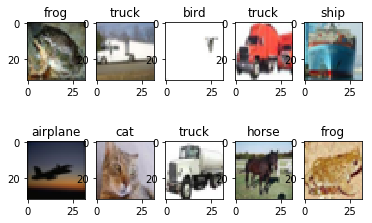

In [210]:
f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, train_size)
    axarr[i, j].imshow(dictionary['data'][index])
    axarr[i, j].set_title(label_names[dictionary['labels'][index]])

"""Visually, we can determine that the loading of data into dictionaries has been done correctly."""

## Convert the dictionaries to numpy arrays.

In [0]:
train_images = np.asarray(dictionary['data'])
train_labels = np.asarray(dictionary['labels'])

test_images = np.asarray(test_dictionary['data'])
test_labels = np.asarray(test_dictionary['labels'])

## Perform some cleanup. 

Though this is not required, I would like to get rid of some unused things.

In [212]:
import gc

del dictionary_raw, dictionary, test_dictionary, tf
gc.collect()

NameError: ignored

# Now, moving on to some pre processing.

The pre processing will include normalization and one hot encoding.

###Normalization

I am going to use **Min-Max Normalization** `(y = (x-min) / (max-min))`,but there are other options too. 
By applying Min-Max normalization, the original image data is going to be transformed in range of 0 to 1 (inclusive). 

In [0]:
def normalize(x):
  
  x = (x-np.min(x))/ (np.max(x) - np.min(x))
  
  return x

train_images = normalize(train_images)
test_images = normalize(test_images)

###One Hot Encode the labels.

In [214]:
def one_hot_encode(Y, C):
  encoded = np.zeros((len(Y), C))
  
  for idx, val in enumerate(Y):
    encoded[idx][val] = 1
  
  return encoded

train_labels = one_hot_encode(train_labels, num_classes)
test_labels = one_hot_encode(test_labels, num_classes)

print(f'The shape of training data: {train_images.shape}')
print(f'The shape of training labels: {train_labels.shape}')
print(f'The shape of test images: {test_images.shape}')
print(f'The shape of test labels: {test_labels.shape}')

The shape of training data: (50000, 32, 32, 3)
The shape of training labels: (50000, 10)
The shape of test images: (10000, 32, 32, 3)
The shape of test labels: (10000, 10)


# Define the model

In [0]:
X = tf.placeholder(tf.float32, shape=(None, im_height, im_width, num_channels), name='input_x')
Y = tf.placeholder(tf.float32, shape=(None, num_classes), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob') # Shape can be found automatically.

def model(x, keep_prob):
  filter1 = tf.get_variable('filter_1', [32, 32, 3, 64], intializer=tf.contrib.layers.xavier_initializer(seed=0))
  filter2 = tf.get_variable('filter_1', [3, 3, 64, 128], intializer=tf.contrib.layers.xavier_initializer(seed=0))
  filter3 = tf.get_variable('filter_1', [5, 5, 128, 256], intializer=tf.contrib.layers.xavier_initializer(seed=0))
  filter4 = tf.get_variable('filter_1', [5, 5, 256, 512], intializer=tf.contrib.layers.xavier_initializer(seed=0))
  
  conv1 = tf.nn.conv2d(x, filter1, strides=[1,1,1,1], padding='SAME')
  conv1 = tf.nn.relu(conv1)
  